### Evaluation of the angles distribution of generated proteins

In [19]:
import sys
import os
os.chdir('..')
print(os.getcwd())  
from omegaconf import OmegaConf
from protein.Nerf import NERFBuilder
from gencomp.diffusion.ddpm import DDPM
import numpy as np
import py3Dmol
from protein.Nerf import NERFBuilder
import numpy as np

/mnt/c/Users/chenwanxin/Documents/GitHub/GenComp


### Try overfitting on one sample

In [33]:
file_path = "protein/sampled_overfitting/length_63/sample_1/protein_sample_63.npy"  
output = np.load(file_path)
reshaped_output = output.T  # Reshape 

# Extract phi, psi, and omega angles
dihedral_tensor = reshaped_output[:, :3]
phi = dihedral_tensor[:, 0] * np.pi  
psi = dihedral_tensor[:, 1] * np.pi  
omega = dihedral_tensor[:, 2] * np.pi  
dihedral_tensor = NERFBuilder(phi, psi, omega)
coordinate = dihedral_tensor.cartesian_coords
pdb_str = ""
atom_names = ['N', 'CA', 'C']
for i in range(0, len(coordinate), 3):
    for j in range(3):
        pdb_str += (
            f"ATOM  {i+j+1:5d}  {atom_names[j]:<2}  GLA A{i//3+1:4d}    "
            f"{coordinate[i+j][0]:8.3f}{coordinate[i+j][1]:8.3f}{coordinate[i+j][2]:8.3f}  1.00  0.00           {atom_names[j][0]}  \n"
        )

# Visualize using py3Dmol
view = py3Dmol.view(width=400, height=300)
view.addModel(pdb_str, 'pdb')
view.setStyle({'stick': {}})
view.zoomTo()
view.show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### Example of one generated protein

In [14]:
file_path = "protein/sampled_proteins/length_90/sample_1/protein_sample_90_1.npy"  
output = np.load(file_path)
reshaped_output = output.T  # Reshape (6, 50) --> (50, 6)

# Extract phi, psi, and omega angles
dihedral_tensor = reshaped_output[:, :3]
phi = dihedral_tensor[:, 0] * np.pi  
psi = dihedral_tensor[:, 1] * np.pi  
omega = dihedral_tensor[:, 2] * np.pi  
dihedral_tensor = NERFBuilder(phi, psi, omega)
coordinate = dihedral_tensor.cartesian_coords
pdb_str = ""
atom_names = ['N', 'CA', 'C']
for i in range(0, len(coordinate), 3):
    for j in range(3):
        pdb_str += (
            f"ATOM  {i+j+1:5d}  {atom_names[j]:<2}  GLA A{i//3+1:4d}    "
            f"{coordinate[i+j][0]:8.3f}{coordinate[i+j][1]:8.3f}{coordinate[i+j][2]:8.3f}  1.00  0.00           {atom_names[j][0]}  \n"
        )

# Visualize using py3Dmol
view = py3Dmol.view(width=400, height=300)
view.addModel(pdb_str, 'pdb')
view.setStyle({'stick': {}})
view.zoomTo()
view.show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
### Test angles distribution of generated proteins
import torch
import os
from biotite.structure.io.pdb import PDBFile
import biotite.structure as struc
from biotite.structure.error import BadStructureError

pdb_directory = "datasets/cath/test"

pdb_paths = [os.path.join(pdb_directory, filename) for filename in os.listdir(pdb_directory) if filename.endswith(".pdb")]

angles_data = {
    "phi": [],
    "psi": [],
    "omega": []
}

for pdb_path in pdb_paths:
    try:
        source = PDBFile.read(pdb_path)
        source_struct = source.get_structure()

        phi, psi, omega = [torch.tensor(x).tolist() for x in struc.dihedral_backbone(source_struct)]

        angles_data["phi"].extend(phi)
        angles_data["psi"].extend(psi)
        angles_data["omega"].extend(omega)
    
    except BadStructureError:
        print(f"Skipped {pdb_path} due to missing backbone atoms.")


KL Divergence between sampled and ground-truth distributions: 0.04239511727024666


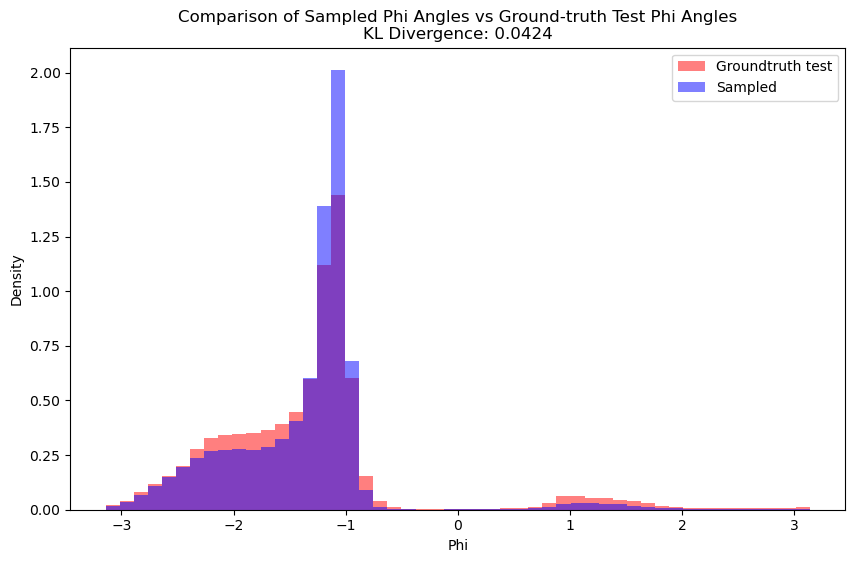

In [4]:
phi_test = angles_data['phi']
phi_test = np.concatenate(phi_test)
phi_test = np.array(phi_test)
#  NaN 
phi_test = phi_test[~np.isnan(phi_test)]
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
base_path = 'code/protein/sampled_proteins'  
# List to store phi angles extracted from sampled data
phi_sample_list = []

# Traverse through each length folder and sample folder
for length_dir in os.listdir(base_path):
    length_path = os.path.join(base_path, length_dir)
    if os.path.isdir(length_path):
        for sample_dir in os.listdir(length_path):
            sample_path = os.path.join(length_path, sample_dir)
            # Assuming each sample folder contains a file with the protein data in (6, length) format
            for filename in os.listdir(sample_path):
                file_path = os.path.join(sample_path, filename)
                # Load the protein data assuming .npy format (update if your files differ)
                protein_data = np.load(file_path)  # Adjust based on actual file format
                if protein_data.shape[0] >= 1:  # Check if protein data has at least 1 row
                    phi_data = protein_data[0]  # Extract the first row (phi angles)
                    phi_sample_list.append(phi_data)

# Concatenate all phi angles and filter out any NaNs
phi_sample = np.concatenate(phi_sample_list)
phi_sample = phi_sample[~np.isnan(phi_sample)]
phi_sample = phi_sample * np.pi  # Scaling by π if needed
# Calculate histograms for ground-truth and sampled data
hist_true, bins = np.histogram(phi_test, bins=50, range=(-np.pi, np.pi), density=True)
hist_sample, _ = np.histogram(phi_sample, bins=bins, density=True)

# Add a small value to both histograms to prevent log(0) errors
hist_true += 1e-8
hist_sample += 1e-8

# Calculate KL divergence
kl_divergence = entropy(hist_sample, hist_true)
print(f"KL Divergence between sampled and ground-truth distributions: {kl_divergence}")

# Plot histogram
plt.figure(figsize=(10, 6))

plt.hist(phi_test, bins=50, alpha=0.5, label='Groundtruth test', color='red', density=True)
plt.hist(phi_sample, bins=50, alpha=0.5, label='Sampled', color='blue', density=True)

plt.title(f'Comparison of Sampled Phi Angles vs Ground-truth Test Phi Angles\nKL Divergence: {kl_divergence:.4f}')
plt.xlabel('Phi')
plt.ylabel('Density')
plt.legend()
plt.show()



KL Divergence between sampled and ground-truth distributions: 0.04381486991447685


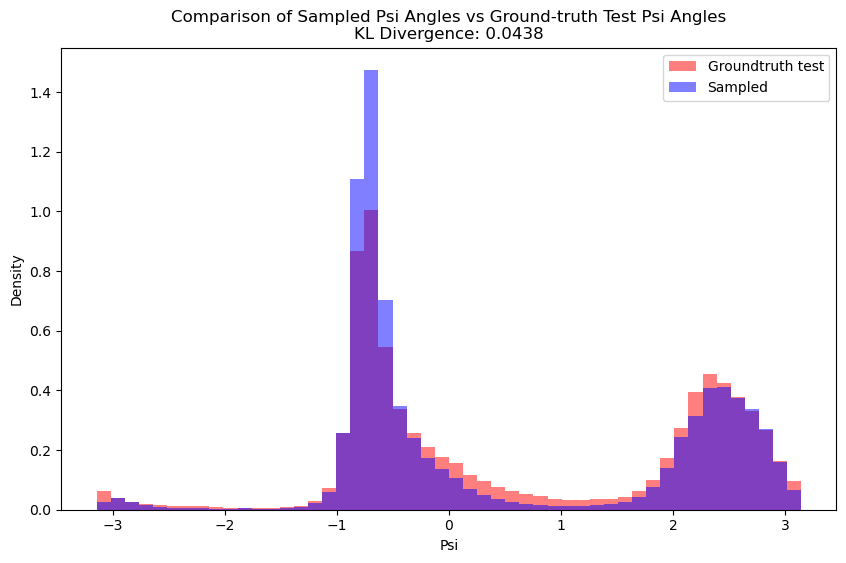

In [5]:
psi_test = angles_data['psi']
psi_test = np.concatenate(psi_test)
psi_test = np.array(psi_test)
#  NaN 
psi_test = psi_test[~np.isnan(psi_test)]
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
base_path = 'code/protein/sampled_proteins'  
# List to store phi angles extracted from sampled data
psi_sample_list = []

# Traverse through each length folder and sample folder
for length_dir in os.listdir(base_path):
    length_path = os.path.join(base_path, length_dir)
    if os.path.isdir(length_path):
        for sample_dir in os.listdir(length_path):
            sample_path = os.path.join(length_path, sample_dir)
            # Assuming each sample folder contains a file with the protein data in (6, length) format
            for filename in os.listdir(sample_path):
                file_path = os.path.join(sample_path, filename)
                # Load the protein data assuming .npy format (update if your files differ)
                protein_data = np.load(file_path)  # Adjust based on actual file format
                if protein_data.shape[0] >= 1:  # Check if protein data has at least 1 row
                    psi_data = protein_data[1]  # Extract the first row (psi angles)
                    psi_sample_list.append(psi_data)

# Concatenate all phi angles and filter out any NaNs
psi_sample = np.concatenate(psi_sample_list)
psi_sample = psi_sample[~np.isnan(psi_sample)]
psi_sample = psi_sample * np.pi  # Scaling by π if needed
# Calculate histograms for ground-truth and sampled data
hist_true, bins = np.histogram(psi_test, bins=50, range=(-np.pi, np.pi), density=True)
hist_sample, _ = np.histogram(psi_sample, bins=bins, density=True)

# Add a small value to both histograms to prevent log(0) errors
hist_true += 1e-8
hist_sample += 1e-8

# Calculate KL divergence
kl_divergence = entropy(hist_sample, hist_true)
print(f"KL Divergence between sampled and ground-truth distributions: {kl_divergence}")

# Plot histogram
plt.figure(figsize=(10, 6))

plt.hist(psi_test, bins=50, alpha=0.5, label='Groundtruth test', color='red', density=True)
plt.hist(psi_sample, bins=50, alpha=0.5, label='Sampled', color='blue', density=True)

plt.title(f'Comparison of Sampled Psi Angles vs Ground-truth Test Psi Angles\nKL Divergence: {kl_divergence:.4f}')
plt.xlabel('Psi')
plt.ylabel('Density')
plt.legend()
plt.show()


KL Divergence between sampled and ground-truth distributions: 0.028393652646837672


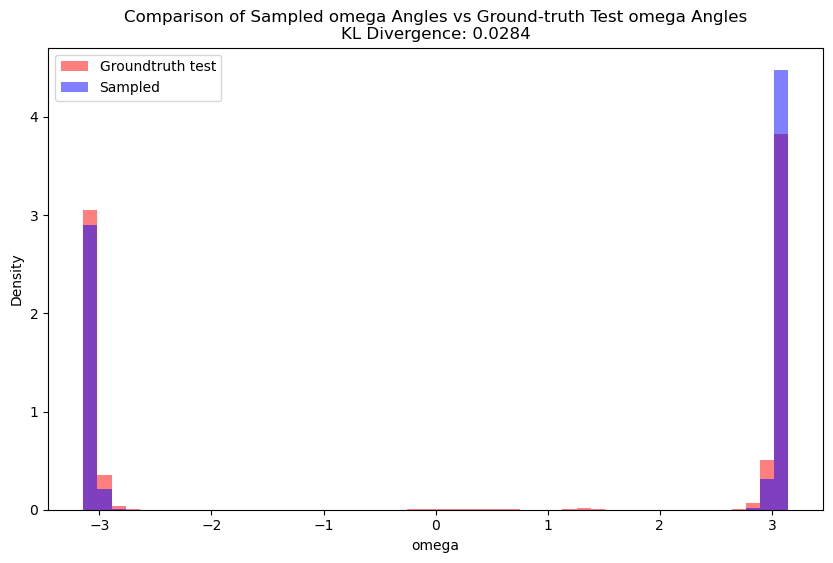

In [6]:
omega_test = angles_data['omega']
omega_test = np.concatenate(omega_test)
omega_test = np.array(omega_test)
#  NaN 
omega_test = omega_test[~np.isnan(omega_test)]
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
base_path = 'code/protein/sampled_proteins'  
# List to store phi angles extracted from sampled data
omega_sample_list = []

# Traverse through each length folder and sample folder
for length_dir in os.listdir(base_path):
    length_path = os.path.join(base_path, length_dir)
    if os.path.isdir(length_path):
        for sample_dir in os.listdir(length_path):
            sample_path = os.path.join(length_path, sample_dir)
            # Assuming each sample folder contains a file with the protein data in (6, length) format
            for filename in os.listdir(sample_path):
                file_path = os.path.join(sample_path, filename)
                # Load the protein data assuming .npy format (update if your files differ)
                protein_data = np.load(file_path)  # Adjust based on actual file format
                if protein_data.shape[0] >= 1:  # Check if protein data has at least 1 row
                    omega_data = protein_data[2]  # Extract the row (omega angles)
                    omega_sample_list.append(omega_data)

# Concatenate all phi angles and filter out any NaNs
omega_sample = np.concatenate(omega_sample_list)
omega_sample = omega_sample[~np.isnan(omega_sample)]
omega_sample = omega_sample * np.pi  # Scaling by π if needed
# Calculate histograms for ground-truth and sampled data
hist_true, bins = np.histogram(omega_test, bins=50, range=(-np.pi, np.pi), density=True)
hist_sample, _ = np.histogram(omega_sample, bins=bins, density=True)

# Add a small value to both histograms to prevent log(0) errors
hist_true += 1e-8
hist_sample += 1e-8

# Calculate KL divergence
kl_divergence = entropy(hist_sample, hist_true)
print(f"KL Divergence between sampled and ground-truth distributions: {kl_divergence}")

# Plot histogram
plt.figure(figsize=(10, 6))

plt.hist(omega_test, bins=50, alpha=0.5, label='Groundtruth test', color='red', density=True)
plt.hist(omega_sample, bins=50, alpha=0.5, label='Sampled', color='blue', density=True)

plt.title(f'Comparison of Sampled omega Angles vs Ground-truth Test omega Angles\nKL Divergence: {kl_divergence:.4f}')
plt.xlabel('omega')
plt.ylabel('Density')
plt.legend()
plt.show()

In [7]:
sys.path.insert(0, os.path.abspath('protein')) 
from angles_and_coordinates import coord_to_angles
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
# Define the directory containing your test PDB files
test_data_dir = 'datasets/cath/test'  # Update this with the actual directory path

# Specify the bond angles to calculate
bond_angles = ["theta_1", "theta_2", "theta_3"]

# List to store theta_1 values from all test data
theta1_test_list = []
theta2_test_list = []
theta3_test_list = []

# Iterate over each PDB file in the test data directory
for pdb_filename in os.listdir(test_data_dir):
    pdb_file_path = os.path.join(test_data_dir, pdb_filename)
    # Calculate bond angles for the current PDB file
    bond_angles_df = coord_to_angles(fname=pdb_file_path, angles=bond_angles)
    # If bond angles were successfully calculated, add theta_1 values to the list
    if bond_angles_df is not None:
        theta1_test_list.extend(bond_angles_df['theta_1'].dropna().values)  # Drop NaNs and extend list
        theta2_test_list.extend(bond_angles_df['theta_2'].dropna().values)
        theta3_test_list.extend(bond_angles_df['theta_3'].dropna().values)
# Combine all theta_1 
theta1_test = np.array(theta1_test_list)
theta2_test = np.array(theta2_test_list)
theta3_test = np.array(theta3_test_list)

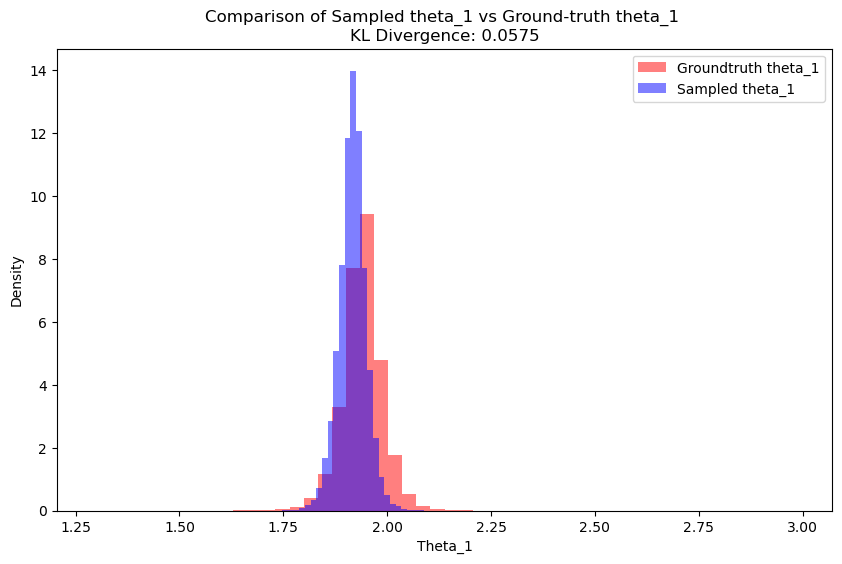

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

# Directory containing sampled data
sampled_data_dir = 'code/protein/sampled_proteins' 
theta1_sample_list = []

# Traverse the sampled output directories
for length_dir in os.listdir(sampled_data_dir):
    length_path = os.path.join(sampled_data_dir, length_dir)
    if os.path.isdir(length_path):
        for sample_dir in os.listdir(length_path):
            sample_path = os.path.join(length_path, sample_dir)
            # Load each sample file
            for filename in os.listdir(sample_path):
                file_path = os.path.join(sample_path, filename)
                if filename.endswith('.npy'):
                    sample_output = np.load(file_path)
                    if sample_output.shape[0] > 3:  # Ensure the fourth row exists
                        theta1_sample = sample_output[3]  # Extract the fourth row (index 3)
                        theta1_sample_list.append(theta1_sample)

# Flatten and concatenate all `theta_1` values from sampled data
theta1_sample = np.concatenate(theta1_sample_list).flatten()
theta1_sample = theta1_sample * np.pi

# Plot histograms
plt.figure(figsize=(10, 6))

plt.hist(theta1_test, bins=50, alpha=0.5, label='Groundtruth theta_1', color='red', density=True)
plt.hist(theta1_sample, bins=50, alpha=0.5, label='Sampled theta_1', color='blue', density=True)

# Calculate histograms for KL divergence calculation
hist_test, bins = np.histogram(theta1_test, bins=50, range=(-np.pi, np.pi), density=True)
hist_sample, _ = np.histogram(theta1_sample, bins=bins, density=True)

# Avoid zero values in histograms by adding a small constant
hist_test += 1e-8
hist_sample += 1e-8

# Calculate KL divergence
kl_divergence = entropy(hist_sample, hist_test)

# Add KL divergence text on the plot
plt.title(f'Comparison of Sampled theta_1 vs Ground-truth theta_1 \nKL Divergence: {kl_divergence:.4f}')
plt.xlabel('Theta_1')
plt.ylabel('Density')
plt.legend()

# Show plot
plt.show()


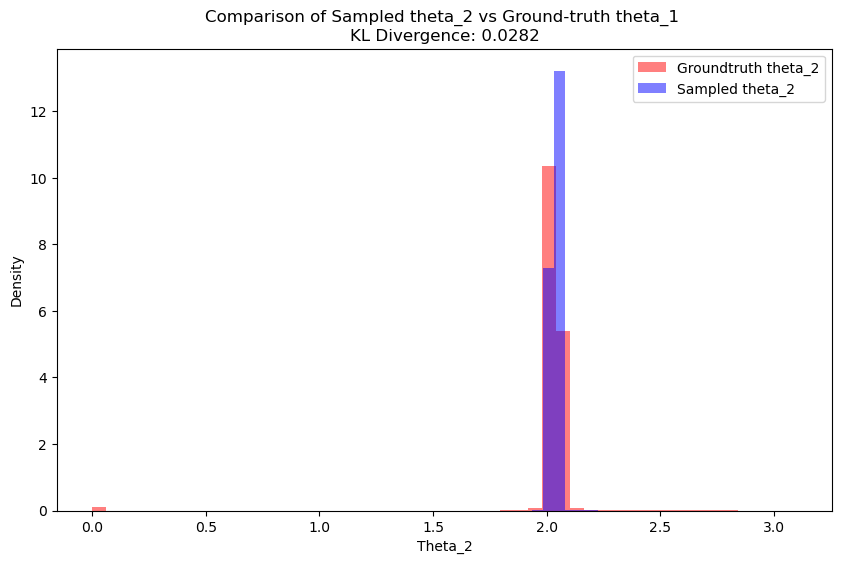

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

# Directory containing sampled data
sampled_data_dir = 'code/protein/sampled_proteins' 
theta2_sample_list = []

# Traverse the sampled output directories
for length_dir in os.listdir(sampled_data_dir):
    length_path = os.path.join(sampled_data_dir, length_dir)
    if os.path.isdir(length_path):
        for sample_dir in os.listdir(length_path):
            sample_path = os.path.join(length_path, sample_dir)
            # Load each sample file
            for filename in os.listdir(sample_path):
                file_path = os.path.join(sample_path, filename)
                if filename.endswith('.npy'):
                    sample_output = np.load(file_path)
                    if sample_output.shape[0] > 4:  # Ensure the fourth row exists
                        theta2_sample = sample_output[4]  # Extract the fourth row (index 3)
                        theta2_sample_list.append(theta2_sample)

theta2_sample = np.concatenate(theta2_sample_list).flatten()
theta2_sample = theta2_sample * np.pi

# Plot histograms
plt.figure(figsize=(10, 6))

plt.hist(theta2_test, bins=50, alpha=0.5, label='Groundtruth theta_2', color='red', density=True)
plt.hist(theta2_sample, bins=50, alpha=0.5, label='Sampled theta_2', color='blue', density=True)

# Calculate histograms for KL divergence calculation
hist_test, bins = np.histogram(theta2_test, bins=50, range=(-np.pi, np.pi), density=True)
hist_sample, _ = np.histogram(theta2_sample, bins=bins, density=True)

# Avoid zero values in histograms by adding a small constant
hist_test += 1e-8
hist_sample += 1e-8

# Calculate KL divergence
kl_divergence = entropy(hist_sample, hist_test)

# Add KL divergence text on the plot
plt.title(f'Comparison of Sampled theta_2 vs Ground-truth theta_1 \nKL Divergence: {kl_divergence:.4f}')
plt.xlabel('Theta_2')
plt.ylabel('Density')
plt.legend()

# Show plot
plt.show()


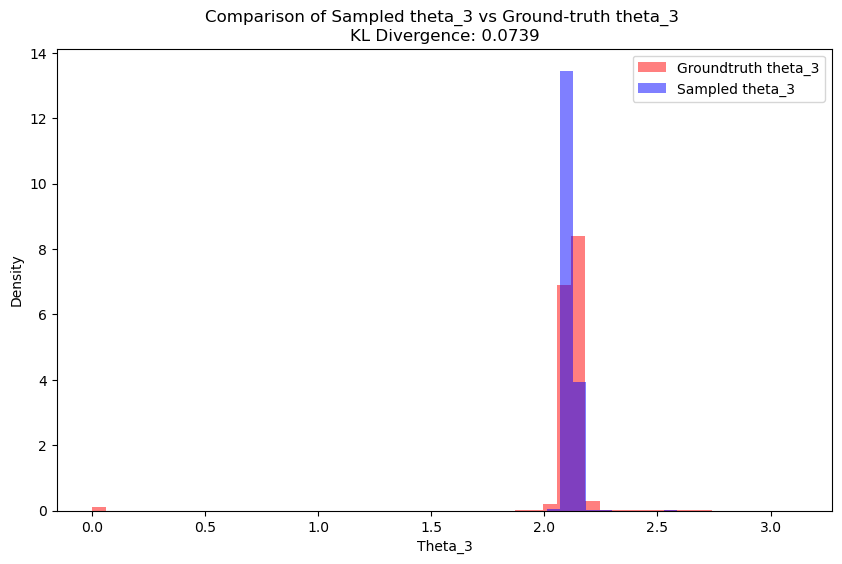

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

# Directory containing sampled data
sampled_data_dir = 'code/protein/sampled_proteins' 
theta3_sample_list = []

# Traverse the sampled output directories
for length_dir in os.listdir(sampled_data_dir):
    length_path = os.path.join(sampled_data_dir, length_dir)
    if os.path.isdir(length_path):
        for sample_dir in os.listdir(length_path):
            sample_path = os.path.join(length_path, sample_dir)
            # Load each sample file
            for filename in os.listdir(sample_path):
                file_path = os.path.join(sample_path, filename)
                if filename.endswith('.npy'):
                    sample_output = np.load(file_path)
                    if sample_output.shape[0] > 5:  # Ensure the fourth row exists
                        theta3_sample = sample_output[5]  # Extract the fourth row (index 3)
                        theta3_sample_list.append(theta3_sample)

theta3_sample = np.concatenate(theta3_sample_list).flatten()
theta3_sample = theta3_sample * np.pi

# Plot histograms
plt.figure(figsize=(10, 6))

plt.hist(theta3_test, bins=50, alpha=0.5, label='Groundtruth theta_3', color='red', density=True)
plt.hist(theta3_sample, bins=50, alpha=0.5, label='Sampled theta_3', color='blue', density=True)

# Calculate histograms for KL divergence calculation
hist_test, bins = np.histogram(theta3_test, bins=50, range=(-np.pi, np.pi), density=True)
hist_sample, _ = np.histogram(theta3_sample, bins=bins, density=True)

# Avoid zero values in histograms by adding a small constant
hist_test += 1e-8
hist_sample += 1e-8

# Calculate KL divergence
kl_divergence = entropy(hist_sample, hist_test)

# Add KL divergence text on the plot
plt.title(f'Comparison of Sampled theta_3 vs Ground-truth theta_3 \nKL Divergence: {kl_divergence:.4f}')
plt.xlabel('Theta_3')
plt.ylabel('Density')
plt.legend()

# Show plot
plt.show()


### Plot Natural Ramachandran 

/home/orangebowl/miniconda3/envs/gencomp-test/lib/python3.8/site-packages/Bio/PDB/vectors.py:357: RuntimeWarning: invalid value encountered in scalar divide
  c = (self * other) / (n1 * n2)


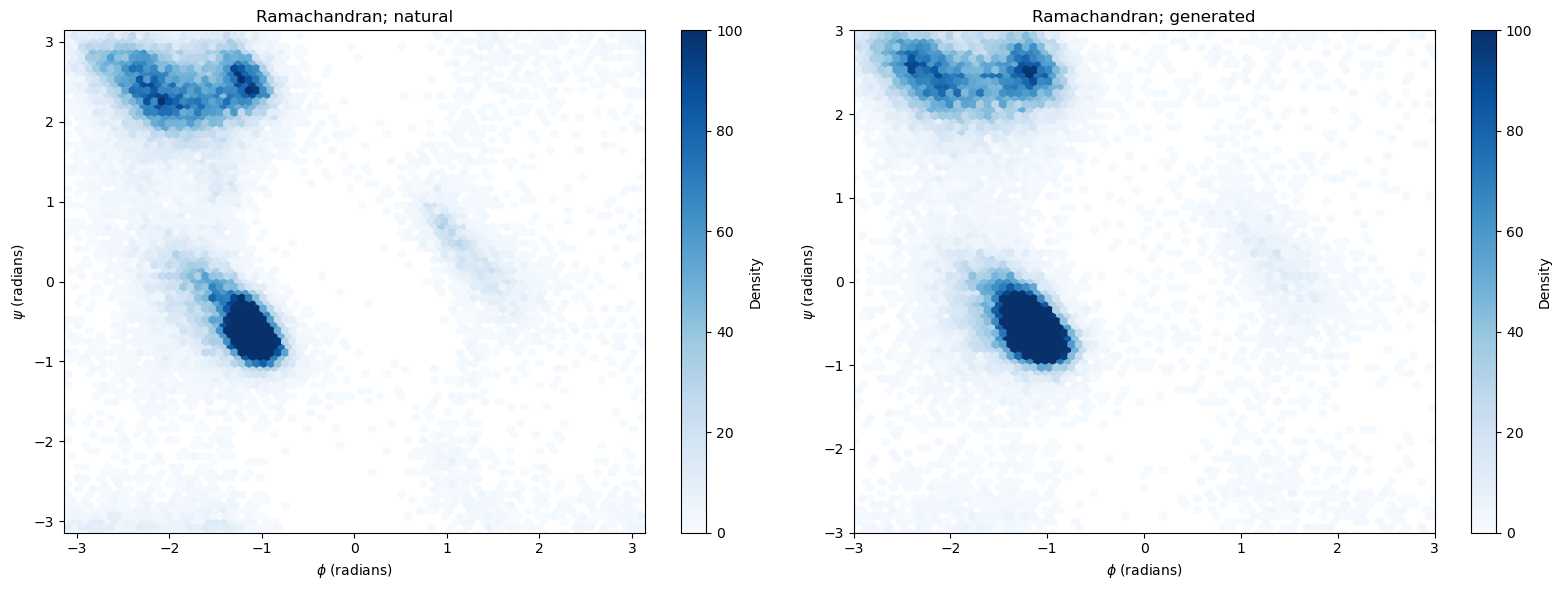

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from Bio import PDB
import os
import glob

pdb_folder = 'datasets/cath/test'  
pdb_files = glob.glob(f'{pdb_folder}/*.pdb')
parser = PDB.PDBParser(QUIET=True)
all_phi_natural = []
all_psi_natural = []

for pdb_file in pdb_files:
    structure = parser.get_structure('protein', pdb_file)
    model = structure[0]
    for chain in model:
        polypeptides = PDB.PPBuilder().build_peptides(chain)
        for poly in polypeptides:
            phi_psi = poly.get_phi_psi_list()
            for phi, psi in phi_psi:
                if phi and psi:
                    all_phi_natural.append(phi)
                    all_psi_natural.append(psi)

all_phi_natural = np.array(all_phi_natural)
all_psi_natural = np.array(all_psi_natural)

output_dir = "generated_samples"
all_phi_generated = []
all_psi_generated = []
start_length = 64
end_length = 128
samples_per_length = 10

for length in range(start_length, end_length + 1):
    for sample_num in range(1, samples_per_length + 1):
        sample_path = os.path.join(output_dir, f"sample_length_{length}_num_{sample_num}.npy")
        sample = np.load(sample_path)
        sample = sample.squeeze(axis=0)
        phi_sample = sample[:, 0]
        psi_sample = sample[:, 1]
        all_phi_generated.append(phi_sample)
        all_psi_generated.append(psi_sample)

all_phi_generated = np.concatenate(all_phi_generated)
all_psi_generated = np.concatenate(all_psi_generated)
all_phi_generated = all_phi_generated * np.pi
all_psi_generated = all_psi_generated * np.pi

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].hexbin(all_phi_natural, all_psi_natural, gridsize=80, cmap='Blues', mincnt=1, vmin=0, vmax=100)
ax[0].set_title("Ramachandran; natural")
ax[0].set_xlabel(r'$\phi$ (radians)')
ax[0].set_ylabel(r'$\psi$ (radians)')
ax[0].set_xlim(-np.pi, np.pi)
ax[0].set_ylim(-np.pi, np.pi)


ax[1].hexbin(all_phi_generated, all_psi_generated, gridsize=80, cmap='Blues', mincnt=1, vmin=0, vmax=100)
ax[1].set_title("Ramachandran; generated")
ax[1].set_xlabel(r'$\phi$ (radians)')
ax[1].set_ylabel(r'$\psi$ (radians)')
ax[1].set_xlim(-3, 3)
ax[1].set_ylim(-3, 3)

fig.colorbar(ax[0].collections[0], ax=ax[0], label='Density')
fig.colorbar(ax[1].collections[0], ax=ax[1], label='Density')

plt.tight_layout()
plt.show()


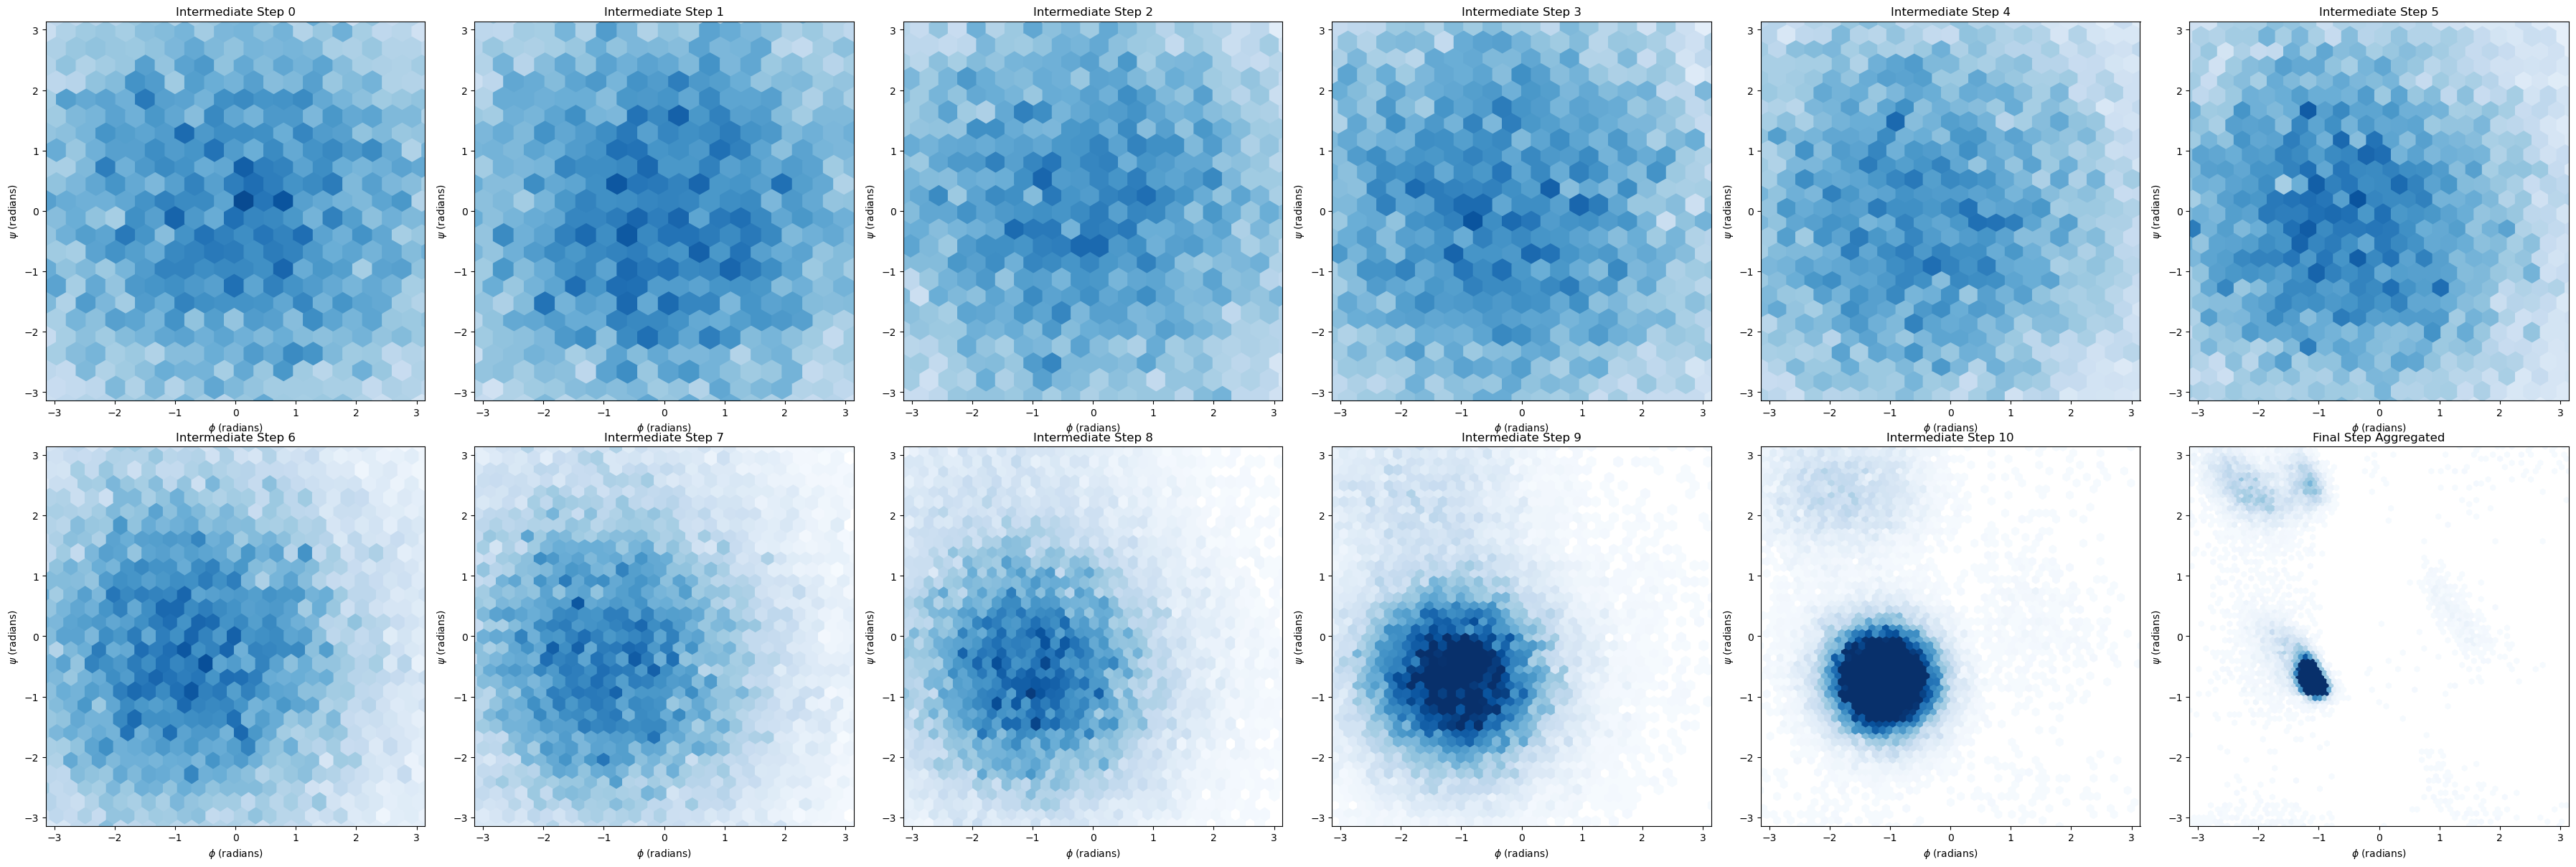

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

### Change the path to the folder you save intermediates!!!
intermediate_dir_base = "/mnt/c/Users/chenwanxin/Documents/GitHub/GenComp/intermediates"
num_samples = 359  # Number of samples
aggregated_intermediate_data = []  # To store (phi_list, psi_list) for each step
final_step_data = ([], [])  # To store phi and psi for the final step

# Initialize the list for each time step
intermediate_files_sample = sorted(glob.glob(f"{intermediate_dir_base}/sample_1/intermediate_step_*.npy"))
num_time_steps = len(intermediate_files_sample)
for _ in range(num_time_steps):
    aggregated_intermediate_data.append(([], []))  # Each element is a tuple (phi list, psi list)

# Aggregate data for the same intermediate step
for step_idx in range(num_time_steps):
    step_name = f"intermediate_step_{step_idx}.npy"  # Assuming the file name format is intermediate_step_#.npy
    for sample_idx in range(1, num_samples + 1):
        intermediate_file = os.path.join(intermediate_dir_base, f"sample_{sample_idx}", step_name)
        try:
            data = np.load(intermediate_file)
            # Remove the first dimension and check the shape
            if data.ndim == 3 and data.shape[0] == 1:
                data = data.squeeze(axis=0)  # Reshape to [6, 128]
            elif data.ndim != 2 or data.shape[0] != 6:
                raise ValueError(f"Unexpected data shape {data.shape} in file {intermediate_file}")
            
            # Extract phi and psi
            phi_intermediate = data[0, :]
            psi_intermediate = data[1, :]
            # Multiply by pi to convert to radians
            phi_intermediate *= np.pi
            psi_intermediate *= np.pi
            aggregated_intermediate_data[step_idx][0].extend(phi_intermediate)
            aggregated_intermediate_data[step_idx][1].extend(psi_intermediate)
        except Exception as e:
            print(f"Error loading file {intermediate_file}: {e}")
            continue

# Process the final step data
for sample_idx in range(1, num_samples + 1):
    final_step_files = glob.glob(os.path.join(intermediate_dir_base, f"sample_{sample_idx}", "final_output_sample_*.npy"))
    if not final_step_files:
        print(f"No final output file found for sample {sample_idx}.")
        continue

    final_step_file = final_step_files[0]
    try:
        data = np.load(final_step_file)
        if data.ndim == 3 and data.shape[0] == 1:
            data = data.squeeze(axis=0)  # Reshape to [6, 128]
        elif data.ndim != 2 or data.shape[0] != 6:
            raise ValueError(f"Unexpected data shape {data.shape} in file {final_step_file}")

        phi_final = data[0, :]
        psi_final = data[1, :]
        # Multiply by pi to convert to radians
        phi_final *= np.pi
        psi_final *= np.pi
        final_step_data[0].extend(phi_final)
        final_step_data[1].extend(psi_final)
    except Exception as e:
        print(f"Error loading file {final_step_file}: {e}")
        continue

# Calculate the number of rows and columns for subplots
num_cols = (num_time_steps + 2) // 2
num_rows = 2

# Make the figure size proportional to the number of rows and columns, ensuring square subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 6, num_rows * 6))

# Plot each intermediate step and the final step
for i, (phi_list, psi_list) in enumerate(aggregated_intermediate_data):
    row = i // num_cols
    col = i % num_cols
    
    ax = axes[row, col]
    ax.hexbin(phi_list, psi_list, gridsize=80, cmap='Blues', mincnt=1, vmin=0, vmax=100)
    ax.set_title(f"Intermediate Step {i}")
    ax.set_xlabel(r'$\phi$ (radians)')
    ax.set_ylabel(r'$\psi$ (radians)')
    ax.set_xlim(-np.pi, np.pi)
    ax.set_ylim(-np.pi, np.pi)
    ax.set_aspect('equal')  # Ensure square plot

# Plot the final step data in the last subplot
final_row = (num_time_steps) // num_cols
final_col = (num_time_steps) % num_cols
ax_final = axes[final_row, final_col]
ax_final.hexbin(final_step_data[0], final_step_data[1], gridsize=80, cmap='Blues', mincnt=1, vmin=0, vmax=100)
ax_final.set_title("Final Step Aggregated")
ax_final.set_xlabel(r'$\phi$ (radians)')
ax_final.set_ylabel(r'$\psi$ (radians)')
ax_final.set_xlim(-np.pi, np.pi)
ax_final.set_ylim(-np.pi, np.pi)
ax_final.set_aspect('equal')  # Ensure square plot

# Adjust the layout
plt.tight_layout()
plt.show()


### Use P-SEA to find secondary structures & Count number of Cluster


Processing protein/intermediates_pdb/t1000/length_128/sample_1/intermediate_step_0.pdb...
Raw SSE output: ['c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c'
 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c'
 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c'
 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c'
 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c'
 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c'
 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c'
 'c' 'c']
Computed cluster count: 128
Total number of clusters for protein/intermediates_pdb/t1000/length_128/sample_1/intermediate_step_0.pdb: 128

Processing protein/intermediates_pdb/t1000/length_128/sample_1/intermediate_step_1.pdb...
Raw SSE output: ['c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c'
 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' '

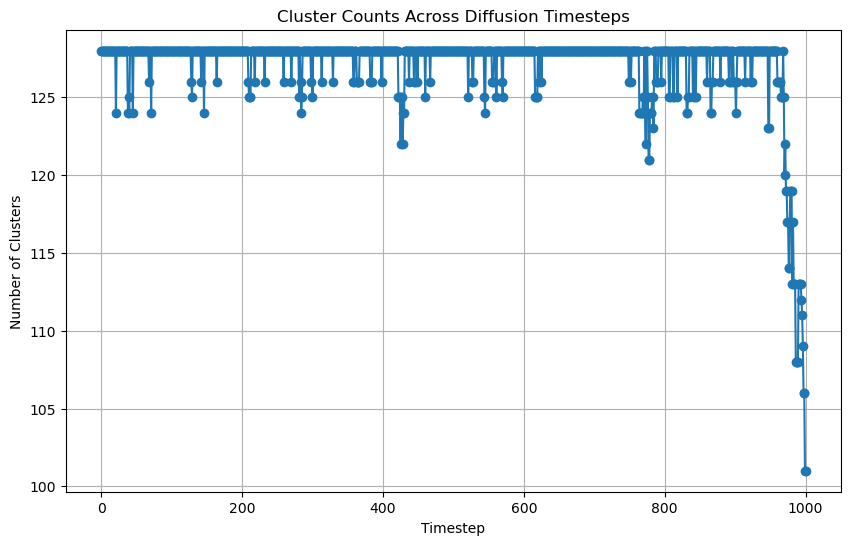

In [21]:
import os
import matplotlib.pyplot as plt
import biotite.structure as struc
from biotite.structure.io.pdb import PDBFile

def annotate_secondary_structure(fname: str):
    """
    Annotate the secondary structure of a protein and count clusters based on the SSE output.
    
    Parameters:
    -----------
    fname : str
        Path to the PDB file.
    
    Returns:
    --------
    int
        The total number of clusters based on the SSE output.
    """
    # Check if the file exists
    if not os.path.exists(fname):
        raise FileNotFoundError(f"The file {fname} does not exist.")
    
    # Read the PDB file
    pdb_file = PDBFile.read(fname)
    structure = pdb_file.get_structure()
    
    # Check if the structure is an AtomArray or AtomArrayStack
    if isinstance(structure, struc.AtomArrayStack):
        structure = structure[0]  # Only process the first model
    
    # Select Cα atoms
    ca_structure = structure[structure.atom_name == "CA"]

    # Check and extract the chain ID
    if len(ca_structure.chain_id) > 0:
        chain_id = ca_structure.chain_id[0]  # Assuming all Cα atoms belong to the same chain
    else:
        raise ValueError("No chain ID found in the Cα atoms.")
    
    # Annotate secondary structure
    sse = struc.annotate_sse(ca_structure, chain_id=chain_id)
    print("Raw SSE output:", sse)  # Print Raw SSE output for inspection
    
    if sse is None:
        print(f"Warning: No SSE found in {fname}")
        return 0  # Return 0 clusters if no SSE is found
    
    # Count clusters
    cluster_count = count_clusters(sse)
    print(f"Total number of clusters for {fname}: {cluster_count}")
    return cluster_count  # Return the cluster count

def count_clusters(sse):
    """
    Count the number of clusters in the secondary structure sequence.

    Parameters:
    ----------- 
    sse : list of str
        A list representing the secondary structure elements, where each element is 
        'a' for Alpha-Helix, 'b' for Beta-Sheet, or 'c' for Coil.

    Returns:
    --------
    int
        The total number of clusters.
    """
    if sse is None:
        return 0  # Handle None case gracefully
    
    cluster_count = 0
    current_type = None  # Track the current structure type in a sequence

    for sse_type in sse:
        if sse_type == 'c':
            # Each Coil is its own cluster
            cluster_count += 1
            current_type = None  # Reset the type since Coil clusters don't continue
        elif sse_type != current_type:
            # New cluster for Alpha-Helix or Beta-Sheet if it's different from the last
            cluster_count += 1
            current_type = sse_type  # Update the current type to the new structure

    print(f"Computed cluster count: {cluster_count}")
    return cluster_count

def plot_cluster_counts(folder_path):
    """
    Process each step file in the folder, calculate cluster counts for each timestep, and plot them.

    Parameters:
    -----------
    folder_path : str
        Path to the folder containing intermediate PDB files for a single sample.
    """
    # Sort files by step index
    step_files = sorted([f for f in os.listdir(folder_path) if f.startswith("intermediate_step_")], 
                        key=lambda x: int(x.split('_')[-1].split('.')[0]))

    cluster_counts = []
    steps = []

    # Process each file to get cluster count for each timestep
    for file in step_files:
        step_num = int(file.split('_')[-1].split('.')[0])
        steps.append(step_num)
        
        file_path = os.path.join(folder_path, file)
        
        try:
            print(f"\nProcessing {file_path}...")
            # Annotate secondary structure and count clusters
            cluster_count = annotate_secondary_structure(file_path)
            cluster_counts.append(cluster_count)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            cluster_counts.append(0)  # Append 0 if there is an error to keep the dimensions consistent

    # Ensure that we only plot if cluster_counts is populated
    if cluster_counts:
        plt.figure(figsize=(10, 6))
        plt.plot(steps, cluster_counts, marker='o', linestyle='-')
        plt.xlabel("Timestep")
        plt.ylabel("Number of Clusters")
        plt.title("Cluster Counts Across Diffusion Timesteps")
        plt.grid()
        plt.show()
    else:
        print("No cluster counts to plot. Please check the input files or function logic.")

### Change the path to the actual pdb files with intermediate step  
folder_path = "protein/intermediates_pdb/t1000/length_128/sample_1"
plot_cluster_counts(folder_path)


### Results for evaluation score for a generated protein

In [52]:
import os
import networkx as nx
from typing import List
from evaluation import remove_consecutive_duplicates,run_evaluation
# Change the path to the intermediate steps in pdb format  
sample_folder_path = "code/protein/intermediates_pdb/t1000/length_128/sample_20"

files = sorted(
    [f for f in os.listdir(sample_folder_path) if f.startswith("intermediate_step_") and f.endswith(".pdb")],
    key=lambda x: int(x.split('_')[-1].split('.')[0])  
)

Gs = []  


for file_name in files:
    file_path = os.path.join(sample_folder_path, file_name)
    
    try:
        print(f"Processing {file_path}...")
        G = annotate_secondary_structure(file_path)  
        Gs.append(G)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")


# remove duplicated graph
Gs = remove_consecutive_duplicates(Gs)
run_evaluation(Gs)

Processing protein/intermediates_pdb/t1000/length_128/sample_20/intermediate_step_0.pdb...
Processing protein/intermediates_pdb/t1000/length_128/sample_20/intermediate_step_1.pdb...
Processing protein/intermediates_pdb/t1000/length_128/sample_20/intermediate_step_2.pdb...
Processing protein/intermediates_pdb/t1000/length_128/sample_20/intermediate_step_3.pdb...
Processing protein/intermediates_pdb/t1000/length_128/sample_20/intermediate_step_4.pdb...
Processing protein/intermediates_pdb/t1000/length_128/sample_20/intermediate_step_5.pdb...
Processing protein/intermediates_pdb/t1000/length_128/sample_20/intermediate_step_6.pdb...
Processing protein/intermediates_pdb/t1000/length_128/sample_20/intermediate_step_7.pdb...
Processing protein/intermediates_pdb/t1000/length_128/sample_20/intermediate_step_8.pdb...
Processing protein/intermediates_pdb/t1000/length_128/sample_20/intermediate_step_9.pdb...
Processing protein/intermediates_pdb/t1000/length_128/sample_20/intermediate_step_10.pdb..

### Calculate the FCR of natural proteins

In [55]:
import warnings
import os
import biotite.structure as struc
from biotite.structure.io.pdb import PDBFile

warnings.simplefilter("ignore", UserWarning)


# Function to process all PDB files in a folder and calculate the length of each SSE and its cluster ratio
def annotate_sse_in_folder(folder_path):
    sse_data_ratios = {}
    for filename in os.listdir(folder_path):
        if filename.endswith(".pdb"):
            file_path = os.path.join(folder_path, filename)
            # Annotate SSE, get the SSE list and cluster count
            sse, cluster_count = annotate_secondary_structure(file_path)
            # Calculate SSE length
            sse_length = len(sse)
            # Calculate the updated cluster-to-length ratio
            ratio = (sse_length - cluster_count) / (sse_length - 1) if sse_length > 1 else 0
            # Store results in a dictionary if length <= 128
            if sse_length <= 128:
                sse_data_ratios[filename] = {
                    "SSE Length": sse_length,
                    "Number of Clusters": cluster_count,
                    "Cluster/Length Ratio": ratio
                }
    return sse_data_ratios

# Calculate the average Cluster/Length Ratio for lengths <= 128
def calculate_average_ratio(sse_data_ratios):
    ratios = [data['Cluster/Length Ratio'] for data in sse_data_ratios.values() if data["SSE Length"] <= 128]
    average_ratio = sum(ratios) / len(ratios) if ratios else 0
    return average_ratio

# Usage example
folder_path = "datasets/cath/test"
sse_data_ratios = annotate_sse_in_folder(folder_path)

# Print the results
for pdb_file, data in sse_data_ratios.items():
    print(f"{pdb_file}: SSE Length = {data['SSE Length']}, Number of Clusters = {data['Number of Clusters']}, Cluster/Length Ratio = {data['Cluster/Length Ratio']:.2f}")

# Calculate and print the average Cluster/Length Ratio across all files with length <= 128
average_ratio = calculate_average_ratio(sse_data_ratios)
print(f"Average Cluster/Length Ratio for SSE Length <= 128: {average_ratio:.2f}")


1a02F00.pdb: SSE Length = 53, Number of Clusters = 3, Cluster/Length Ratio = 0.96
1a02J00.pdb: SSE Length = 52, Number of Clusters = 3, Cluster/Length Ratio = 0.96
1a04A01.pdb: SSE Length = 124, Number of Clusters = 60, Cluster/Length Ratio = 0.52
1a0aA00.pdb: SSE Length = 63, Number of Clusters = 39, Cluster/Length Ratio = 0.39
1a0hA01.pdb: SSE Length = 89, Number of Clusters = 80, Cluster/Length Ratio = 0.10
1a0hA02.pdb: SSE Length = 70, Number of Clusters = 63, Cluster/Length Ratio = 0.10
1a0iA01.pdb: SSE Length = 83, Number of Clusters = 51, Cluster/Length Ratio = 0.39
1a0iA02.pdb: SSE Length = 101, Number of Clusters = 80, Cluster/Length Ratio = 0.21
1a0pA01.pdb: SSE Length = 91, Number of Clusters = 32, Cluster/Length Ratio = 0.66
1a0rP02.pdb: SSE Length = 53, Number of Clusters = 25, Cluster/Length Ratio = 0.54
1a10I00.pdb: SSE Length = 63, Number of Clusters = 41, Cluster/Length Ratio = 0.35
1a15A00.pdb: SSE Length = 67, Number of Clusters = 46, Cluster/Length Ratio = 0.32
1a19

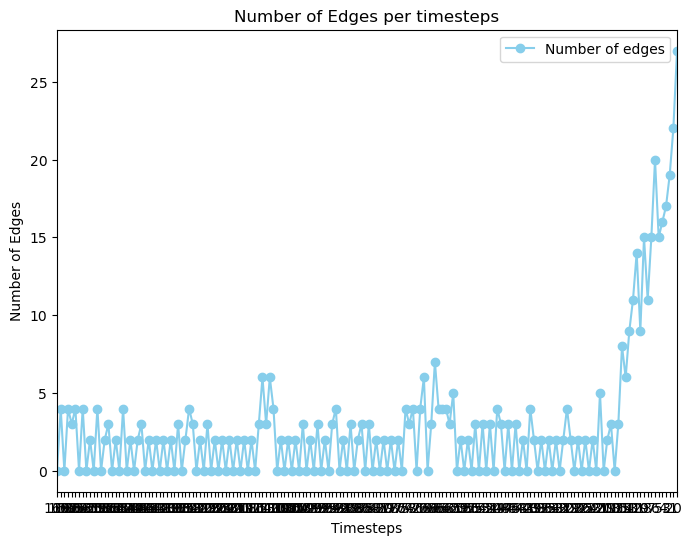

In [7]:
from evaluation import plot_edges, plot_clusters
plot_edges(Gs)

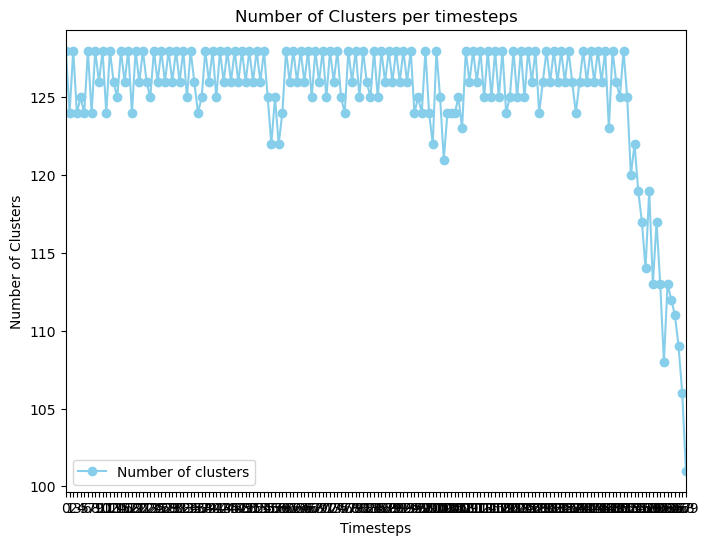

In [8]:
plot_clusters(Gs)